# Sleep, Predation, and the Brain in Mammals
## Chris Boor, Meaghan Calendo, Brandon Dubbs, Nicole Tai


**Sleep is essential to life. Lack of it has been proven to delay physiological 
development and shorten lives. But little is known about the evolution and
role of sleep.**

Towards this end, we will perform data analysis on sleep data collected from 63 animals, as presented in$^1$  

## Import and clean data
***
We first need to import and clean our data to make it more manageable to use in our algorithms. From that point, we can visualize some relationships and see if we can find any patterns within the data. Cleaning our data specifically, is non trivial due to the imbalance as well as the missing points, in addition to the small size overall. So we face significant challenges.

In [54]:
#import packages/libraries
#!pip install --user ete3
#!pip install --user PyQt5
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from IPython.core.display import HTML 
#from ete3 import Tree, TreeStyle, faces, AttrFace, NodeStyle, COLOR_SCHEMES
#%matplotlib notebook #you may have to use this instead of the line below if an IPython errors occur
%matplotlib inline

In [55]:
#import animal data
url = 'https://github.com/ChrisBoor/neuroscience/blob/master/animals%20organized.xlsx?raw=true'
animals = pd.ExcelFile(url).parse(0)
animals.head()

,species of animal,body weight (kg),brain weight in g,slow wave (nondreaming) sleep (hrs/day),paradoxical (dreaming) sleep (hrs/day),total sleep (hrs/day) (sum of slow wave and pardoxical sleep),maximum life span (years),gestation time (days),predation index (1-5),sleep exposure index (1-5),overall danger index (1-5)
0,African elephant,6654.000,5712.0,-999.0,-999.0,3.3,38.6,645.0,3,5,3
1,African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3
2,Arctic Fox,3.385,44.5,-999.0,-999.0,12.5,14.0,60.0,1,1,1
3,Arctic ground squirrel,0.920,5.7,-999.0,-999.0,16.5,-999.0,25.0,5,2,3
4,Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3,5,4


In [56]:
#rename columns
animals.rename(columns={'brain weight in g': 'brain weight (g)',
                        'slow wave (nondreaming) sleep (hrs/day)':'slow wave sleep',
                        'paradoxical (dreaming) sleep (hrs/day)':'paradoxical sleep',
                        'total sleep (hrs/day) (sum of slow wave and pardoxical sleep)':'total sleep',
                        'predation index (1-5)': 'predation index'}, 
                 inplace=True)
animals.head()

,species of animal,body weight (kg),brain weight (g),slow wave sleep,paradoxical sleep,total sleep,maximum life span (years),gestation time (days),predation index,sleep exposure index (1-5),overall danger index (1-5)
0,African elephant,6654.000,5712.0,-999.0,-999.0,3.3,38.6,645.0,3,5,3
1,African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3
2,Arctic Fox,3.385,44.5,-999.0,-999.0,12.5,14.0,60.0,1,1,1
3,Arctic ground squirrel,0.920,5.7,-999.0,-999.0,16.5,-999.0,25.0,5,2,3
4,Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3,5,4


We are interested in discovering correlations the two recorded stages of sleeps (slow wave and paradoxical) may have with the rest of our data.

### Nondreaming vs Dreaming Sleep

Electroencephalogram (EEG) traces can show the distinction between the different 
stages of sleep.

#### Slow wave sleep (Nondreaming)

More commonly referred to as nREM sleep. Deepest stage of sleep. This is when the
body undergoes maintenance. Wounds heal, white blood cells are created to aid body 
defenses, muscle restore, growth hormones are release. Critical for learning and 
ongoing brain development. Parasympathetic nervous system predominates, and 
general metabolism slows. Sensory info from the outside world doesn’t reach the 
cortex. Neurons in ventrolateral preoptic area (vIPOA) increase firing, releasing 
GABA. Inhibition of arousal neurotransmitters (ACh, NE, Serotonin, Histamine, 
Orexin) lead to slow wave sleep.

#### Paradoxical sleep (Dreaming)

More commonly referred to as REM sleep. Occurs 90 minutes after falling asleep.  
Brain waves are almost identical to when you’re awake, but in a paralyzed body 
(total loss of muscle tonus). Rapid eye movement is generated from the pontine 
reticular formation and transmitted to the motor layers of the superior colliculi. The 
collicular neurons then send projections to the paramedian pontine reticular 
formation, which coordinates the duration and direction of these eye movements. 
The brain’s oxygen consumption (which reflects energy consumption) is higher in 
REM sleep than when awake. Complex interaction between nuclei in the brainstem, 
structures in the limbic system, and areas in the cortex cause REM sleep$^2$.

![Image of Sleep](https://i.imgur.com/dDyQtLm.png)

# Impute missing values for dreaming states (slow wave and paradoxical)

**Both  slow wave sleep and paradoxical sleep columns are missing data (indicated by -999.0 values). In order to determine the effect of dreaming states on predation index, we must impute the data. Given the range of data, imputing with mean or median will probably not be very accurate.**

**Instead, we consider using linear regression. In order for regression to work, the predicted value must be normally distributed. We can check this by plotting histograms for nondreaming sleep and dreaming sleep.**

In [57]:
#drop missing values of slow wave and paradoxical sleep (they are what we are trying to predict)
animals_full = animals[animals["slow wave sleep"] != -999.0]
animals_full = animals_full[animals_full["paradoxical sleep"] != -999.0]

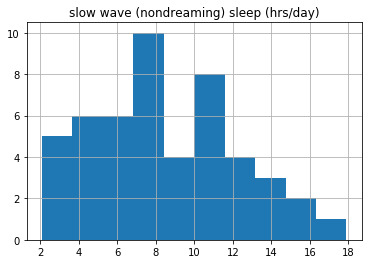

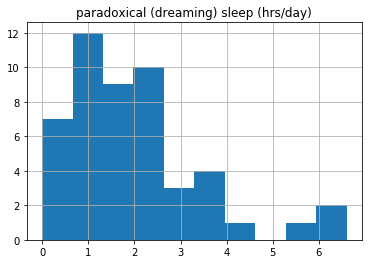

<Figure size 432x288 with 0 Axes>

In [58]:
def plot_slow_hist(animals_full):
    #plot a histogram of slow wave sleep
    plt.title("slow wave (nondreaming) sleep (hrs/day)")
    animals_full["slow wave sleep"].hist()
    plt.figure()
    return


def plot_para_hist(animals_full):
    #plot a histogram of paradoxical sleep
    plt.title("paradoxical (dreaming) sleep (hrs/day)")
    animals_full["paradoxical sleep"].hist()
    plt.figure()
    return

plot_slow_hist(animals_full)
plot_para_hist(animals_full)

**The histograms show that nondreaming sleep is relatively normally distributed, while dreaming sleep is left-skewed. For regression to work, there should also be some sort of relationship between the predictor and the predicted values. Thus, we need to check the relationship between total sleep and nondreaming sleep and total sleep and dreaming sleep.**

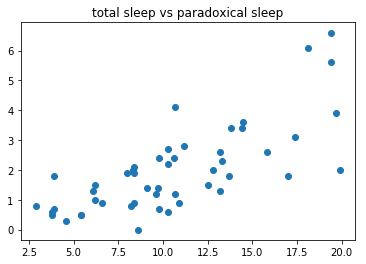

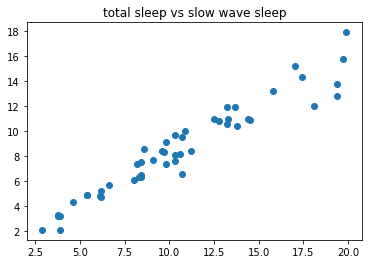

<Figure size 432x288 with 0 Axes>

In [59]:
def plot_paradoxical(animals_full):
    #plot scatterplot between total sleep and paradoxical sleep
    plt.title("total sleep vs paradoxical sleep")
    plt.scatter(animals_full["total sleep"], animals_full["paradoxical sleep"])
    plt.figure()
    return

def plot_slow_wave(animals_full):
    #plot scatterplot between total sleep and slow wave sleep
    plt.title("total sleep vs slow wave sleep")
    plt.scatter(animals_full["total sleep"], animals_full["slow wave sleep"])
    plt.figure()
    return

plot_paradoxical(animals_full)
plot_slow_wave(animals_full)

**The scatterplots show that there is a strong positive correlation between total sleep and slow wave sleep. There is a vague positive correlation between total sleep and paradoxical sleep.**

**Given the results of the histograms and scatterplots, we should use total sleep to predict slow wave sleep. Slow wave sleep has a relatively normal distribution and there is a correlation between total sleep and slow wave sleep, both requirements for regression. Since total sleep is the sum of slow wave sleep and paradoxical sleep, we can impute the values of slow wave sleep using regression and calculate the missing values of paradoxical sleep by subtracting slow wave sleep from total sleep.**

**We will now run the regression, using total sleep as x and slow wave sleep as y.**

In [60]:
def regression(animals_full):
    X = animals_full["total sleep"]
    X = sm.add_constant(X)
    y = animals_full["slow wave sleep"]
    model = sm.OLS(y,X).fit()
    print(model.summary())
    return

regression(animals_full)

                            OLS Regression Results                            
Dep. Variable:        slow wave sleep   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     612.8
Date:                Thu, 25 Apr 2019   Prob (F-statistic):           1.31e-28
Time:                        05:00:15   Log-Likelihood:                -68.160
No. Observations:                  49   AIC:                             140.3
Df Residuals:                      47   BIC:                             144.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4538      0.358      1.269      

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**The regression results show an adjusted R-squared value of 0.927. This means the predictive value of the model is strong (total sleep is responsible for 92.7% of the variance in slow wave sleep).**

**In Excel, we manually updated the missing slow wave sleep values using the equation y = 0.7687x + 0.4538 obtained from the regression results. Then, we imputed the missing paradoxical sleep values using total sleep minus slow wave sleep. The dataset with all imputed values for dreaming is shown below. Moreover, animals are now grouped by their phylogenetic order**

In [61]:
animals = pd.ExcelFile(url).parse(2)
animals.rename(columns={'brain weight in g': 'brain weight (g)',
                        'slow wave (nondreaming) sleep (hrs/day)':'slow wave sleep',
                        'paradoxical (dreaming) sleep (hrs/day)':'paradoxical sleep',
                        'total sleep (hrs/day) (sum of slow wave and pardoxical sleep)':'total sleep',
                        'predation index (1-5)': 'predation index'}, 
                 inplace=True)
animals.head()

,species of animal,body weight (kg),brain weight (g),slow wave sleep,paradoxical sleep,total sleep,nondreaming-total,dreaming-total,maximum life span (years),gestation time (days),predation index,sleep exposure index (1-5),overall danger index (1-5)
0,Galago,0.20,5.0,9.5000,1.2000,10.7,0.887850,0.112150,10.4,120.0,2,2,2
1,Slow loris,1.40,12.5,8.8827,2.1173,11.0,0.807518,0.192482,12.7,90.0,2,2,2
2,Patas monkey,10.00,115.0,10.0000,0.9000,10.9,0.917431,0.082569,20.2,170.0,4,4,4
3,Baboon,10.55,179.5,9.1000,0.7000,9.8,0.928571,0.071429,27.0,180.0,4,4,4
4,Vervet,4.19,58.0,9.7000,0.6000,10.3,0.941748,0.058252,24.0,210.0,4,3,4


# Analyze the relationship between dreaming state and predation index
***
**We can once again use a scatterplot to visually determine the relationship between slow wave sleep and predation index and paradoxical sleep and predation index.**

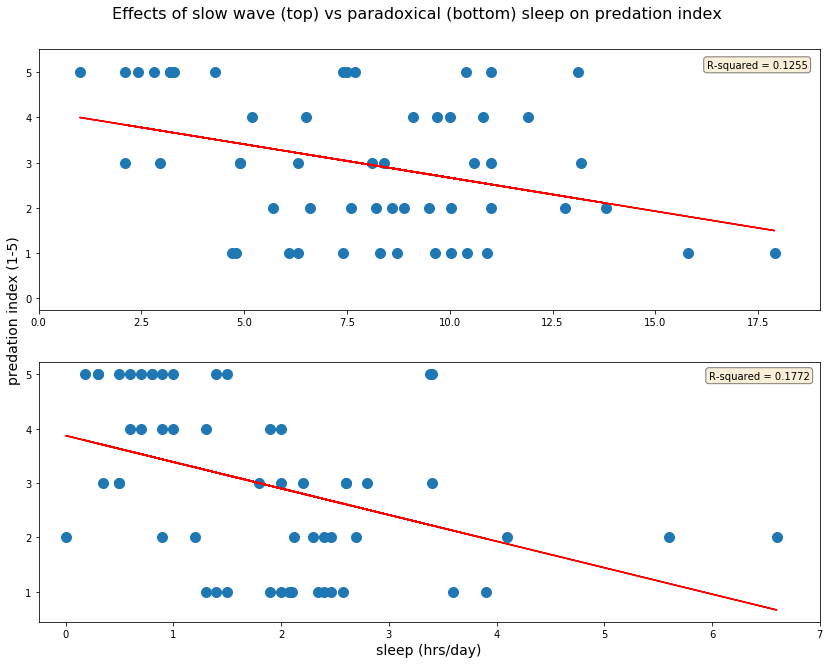

In [62]:
def plot_relationships(animals):
    fig = plt.figure(figsize=(14,10))
    plt.tight_layout()
    #add title
    fig.suptitle('Effects of slow wave (top) vs paradoxical (bottom) sleep on predation index', size=16)
    fig.subplots_adjust(top=0.92)

    #add first subplot (slow wave sleep vs predation index)
    ax1 = fig.add_subplot(211)
    #set axis limits
    ax1.set_xlim([0, 19])
    ax1.set_ylim([-0.25, 5.5])
    ax1.scatter(animals["slow wave sleep"], animals["predation index"],s=100)
    #determine r-squared value
    slope, intercept, r_value, p_value, std_err = stats.linregress(animals["slow wave sleep"],animals["predation index"])
    line = slope*animals["slow wave sleep"]+intercept
    ax1.plot(animals["slow wave sleep"], line, 'r', label='fitted line')
    r_squared = round(r_value**2,4)
    text = "R-squared = " + str(r_squared)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #add r-squared text box to plot
    plt.text(16.25, 5.27, text, fontsize=10,
            verticalalignment='top', bbox=props)

    #add second subplot (paradoxical sleep vs predation index)
    ax2 = fig.add_subplot(212)
    ax2.set_xlim([-0.25, 7])
    ax2.scatter(animals["paradoxical sleep"], animals["predation index"],s=100)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(animals["paradoxical sleep"],animals["predation index"])
    line1 = slope1*animals["paradoxical sleep"]+intercept1
    plt.plot(animals["paradoxical sleep"], line1, 'r', label='fitted line')
    r_squared1 = round(r_value1**2,4)
    text1 = "R-squared = " + str(r_squared1)
    props1 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(5.97, 5.07, text1, fontsize=10,
            verticalalignment='top', bbox=props1)
    plt.xlabel('sleep (hrs/day)', size = 14)
    plt.ylabel('predation index (1-5)', size = 14, y= 1.2)
    
    return

plot_relationships(animals)

**The R-squared values for both plots show that neither slow wave sleep or paradoxical sleep have a significant effect on predation index.**

# Analyze relationships with evolutionary class in consideration

Different types of animals require different amounts of sleep. It is well known that Armadillos sleep over 18 hours a day, while African elephants sleep 3-4 hours a day. All organisms show regulation of the same sleep-associated processes, the thinking is that conserved genetic mechanisms underlie sleep across species$^3$. With this knowledge in mind, patterns in sleep calculated by our analyses are more obviously observed when individuals are divided by their phylogenetic tree.

We generate a Newick Tree using the NCBI Common Taxonomy Tree tool. For further analysis/visualization, we incorporate the tree into an equivalent Python data structure using the ete3 library. (*see supplement*)

![Image of Sleep](https://i.imgur.com/kXtZr4p.jpg)

Above, the green spheres next to the scientific names represent total sleep, and the red circles represent predation index. *Note: using ete3 we can cleanly recover the orders and directly and calculate statistics, otherwise we have to hardcode the selection*

In [63]:
orders.append(animals.iloc[0:8])
orders.append(animals.iloc[8:16])
orders.append(animals.iloc[16:18])
orders.append(animals.iloc[18:21])
orders.append(animals.iloc[21:24])
orders.append(animals.iloc[24])
orders.append(animals.iloc[25])
orders.append(animals.iloc[26:28])
orders.append(animals.iloc[28:31])
orders.append(animals.iloc[31])
orders.append(animals.iloc[32:42])
orders.append(animals.iloc[42:44])
orders.append(animals.iloc[44])
orders.append(animals.iloc[45])
orders.append(animals.iloc[46:48])
orders.append(animals.iloc[48:54])
orders.append(animals.iloc[54])    

Why certain animals spend more time in REM sleep is widely unknown. Previous studies have failed to find a correlation between the obvious assumptions that animals with bigger brains need more time in REM sleep; the article referenced in 1.) from which we obtained our data, concludes that a negative correlation exists between time spent in slow wave sleep vs. brain size. We will test the validity of their conclusion by running our own correlation test on the given data.  

**Then, we use matplotlib to visualize these evolutionary relationships on 3d scatterplots.**

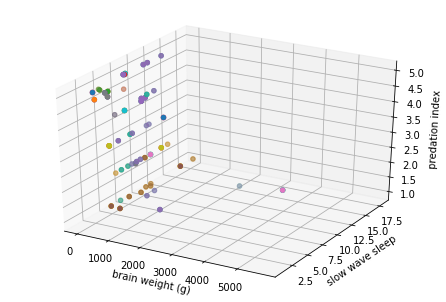

In [64]:
fig = pyplot.figure()
ax = Axes3D(fig)
for i in range(0, len(orders)):
    ax.scatter(orders[i]["brain weight (g)"], orders[i]["slow wave sleep"], orders[i]["predation index"])

ax.set_xlabel('brain weight (g)')
ax.set_ylabel('slow wave sleep')
ax.set_zlabel('predation index')
pyplot.show()

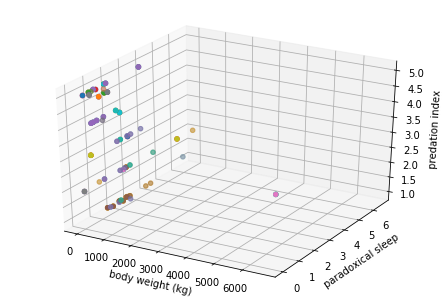

In [65]:
fig = pyplot.figure()
ax = Axes3D(fig)
for i in range(0, len(orders)):
    ax.scatter(orders[i]["body weight (kg)"], orders[i]["paradoxical sleep"], orders[i]["predation index"])

ax.set_xlabel('body weight (kg)')
ax.set_ylabel('paradoxical sleep')
ax.set_zlabel('predation index')
pyplot.show()

# Final Results
***

Though the results do not indicate a strong correlation between body/brain weight or dreaming state and predation index, we are able to see that evolutionary class is definitely related to predation index. This is somewhat unsurprising, but interesting nonetheless. We think that though this dataset is very limited on what we can really get from it, a future dataset might be very interesting to look into. Also, given that some major animals in the animal kindom were left out (consider big cats, bears, moose, elk and others), there might be way more insights that could be found with a similar project, but with a greater magnitude.

It is worth seeing the relationship that we saw with simplistic bar graph on our presentation. You can see that overall sleep does play a role in the predation and overall danger index, but does not seem to have the same effect on maximum lifespan, which is pretty interesting. We think that it could be that the lifespan is the *maximum* and not the average, which might be more indicitive  of a trend. The following charts were made in Tableau. 

![Image of Sleep](https://i.imgur.com/0aNJUdQ.png)

##### References
1. Allison Truett and Domenic Ciccheti. 976. Sleep in Mammals: Ecological and Constitutional Correlates. Science 194, Article 4266 (Nov. 1976), 732-734.
2. Amanda Crocker and Amita Sehgal. Genetic Analysis of Sleep. Genes & Dev. 2010. 24: 1220-1235.  
3. The origins and evolution of sleep. Alex C. Keene, Erik R. Duboue. Journal of Experimental Biology, Jun. 2018 221.
4. Scott Campbell and Irene Tobler. Animal Sleep: A review of Sleep Duration Across Phylogeny. Neuroscience and Behaviorial Reviews. 1984. 8: 269-300.
5. Ethan Shaw. How Do Giraffes Sleep? Mar. 2018. 